# ПРОЕКТ

**Тематическое моделирование на датасете от Quora с использованием NMF (Non-Negative Matrix Factorization)**

*Цель проекта:*

Определение тематики вопросов на  сайте Quora.

*Исходные данные:*

Набор вопросов от Quora. Это коллекция текстовых документов, каждый из которых представляет собой вопрос в этой соцсети.

*Этапы работы:*

- Подготовка данных

Загрузка датасета.
Векторизация и предобработка текста: удаление стоп-слов, приведение слов к нижнему регистру, преобразование в машиночитаемый формат с помощью TfIdfVectorizer


- Тематическое моделирование с использованием Non-negative Matrix Factorization

Выбор числа тем для моделирования.
Обучение NMF модели на подготовленных данных.
Анализ полученных тем: просмотр ключевых слов для каждой темы.

- Анализ результатов

Присвоение тем каждому вопросу на основе полученной модели NMF (Non-Negative Matrix Factorization).
Визуализация распределения слов среди тем.

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загрузка датасета
quora = pd.read_csv(r"C:\Users\aliak\OneDrive\Desktop\quora_questions.csv")
quora.head()

,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


In [3]:
#смотрим размерность
quora.shape

(404289, 1)

In [4]:
#смотрим полные дубликаты
quora.duplicated().sum()

113833

In [5]:
#удаляем полные дубликаты
quora = quora.drop_duplicates()
quora.shape

(290456, 1)

In [6]:
#смотрим пропуски дубликаты
quora.isna().sum()

Question    0
dtype: int64

In [7]:
#проверяем, есть ли пробелы вместо текста
lines_spaces = quora['Question'].apply(lambda x: isinstance(x, str) and x.isspace())
quora[lines_spaces]

,Question


Объём после удаления дубликатов - 290456. Пустых строк или строк, состоящих из пробелов, не оказалось.

Переходим к векторизации. Возьмем TfIdfVectirozer, так как нам важна частота терминов в документах. Этот метод также сразу очистит текст.

In [8]:
#сразу определим минимальную и максимальную встречаемость терминов - максимум в 95% документов и как минимум 2 раза
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [9]:
#создаем разреженную матрицу и сразу просматриваем её
dtm = tfidf.fit_transform(quora['Question'])
dtm

<290456x35172 sparse matrix of type '<class 'numpy.float64'>'
	with 1451024 stored elements in Compressed Sparse Row format>

In [10]:
#пусть тем будет 20
nmf_model = NMF(n_components=20,random_state=1136)

In [11]:
#применяем модель
nmf_model.fit(dtm)

NMF(n_components=20, random_state=1136)

In [12]:
#Выведем самые частые слова для каждой темы
for index,topic in enumerate(nmf_model.components_):
    print(f'15 самых употребляеых слова для темы номер {index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

15 самых употребляеых слова для темы номер 0
['app', 'laptop', 'movie', 'places', '2016', 'thing', 'friend', 'place', 'buy', 'online', 'ways', 'movies', 'book', 'books', 'best']


15 самых употребляеых слова для темы номер 1
['really', 'universities', 'majors', 'affect', 'says', 'grads', 'recruit', 'looking', 'exist', 'compare', 'cost', 'long', 'feel', 'mean', 'does']


15 самых употребляеых слова для темы номер 2
['talk', 'care', 'god', 'blowing', 'mind', 'white', 'want', 'say', 'black', 'chinese', 'believe', 'hate', 'don', 'think', 'people']


15 самых употребляеых слова для темы номер 3
['companies', 'guys', 'guy', 'indian', 'men', 'don', 'culture', 'women', 'girls', 'sex', 'girl', 'live', 'look', 'feel', 'like']


15 самых употребляеых слова для темы номер 4
['ideas', 'university', 'makes', 'movies', 'score', 'songs', 'idea', 'book', 'college', 'read', 'engineering', 'ways', 'bad', 'books', 'good']


15 самых употребляеых слова для темы номер 5
['future', 'colleges', 'salary', 'min

In [13]:
#применяем модель NMF к матрице dtm
topic_results = nmf_model.transform(dtm)

In [14]:
#зададим названия тем
topic_labels = {
    0: "Shopping and entertainment",
    1: "Education and work",
    2: "Personal opinions",
    3: "Culture and relationships",
    4: "Reading and studies",
    5: "Careers wordlwide",
    6: "Online platforms and interactions",
    7: "Online earnings and social media",
    8: "Life philosophies",
    9: "Human and programming languages",
    10: "Personal insights and knowledge",
    11: "Engineering disciplines",
    12: "Love and personal relationships",
    13: "Politics and elections",
    14: "Career goals and startups",
    15: "Improvement and solutions",
    16: "Leisure and time management",
    17: "Jobs and corporate environment",
    18: "World views and changes",
    19: "Technology and usage"
}

quora['topic_number'] = topic_results.argmax(axis=1)

# Создаем столбец 'labels', присваивая названия тем на основе номера
quora['labels'] = quora['topic_number'].map(topic_labels)

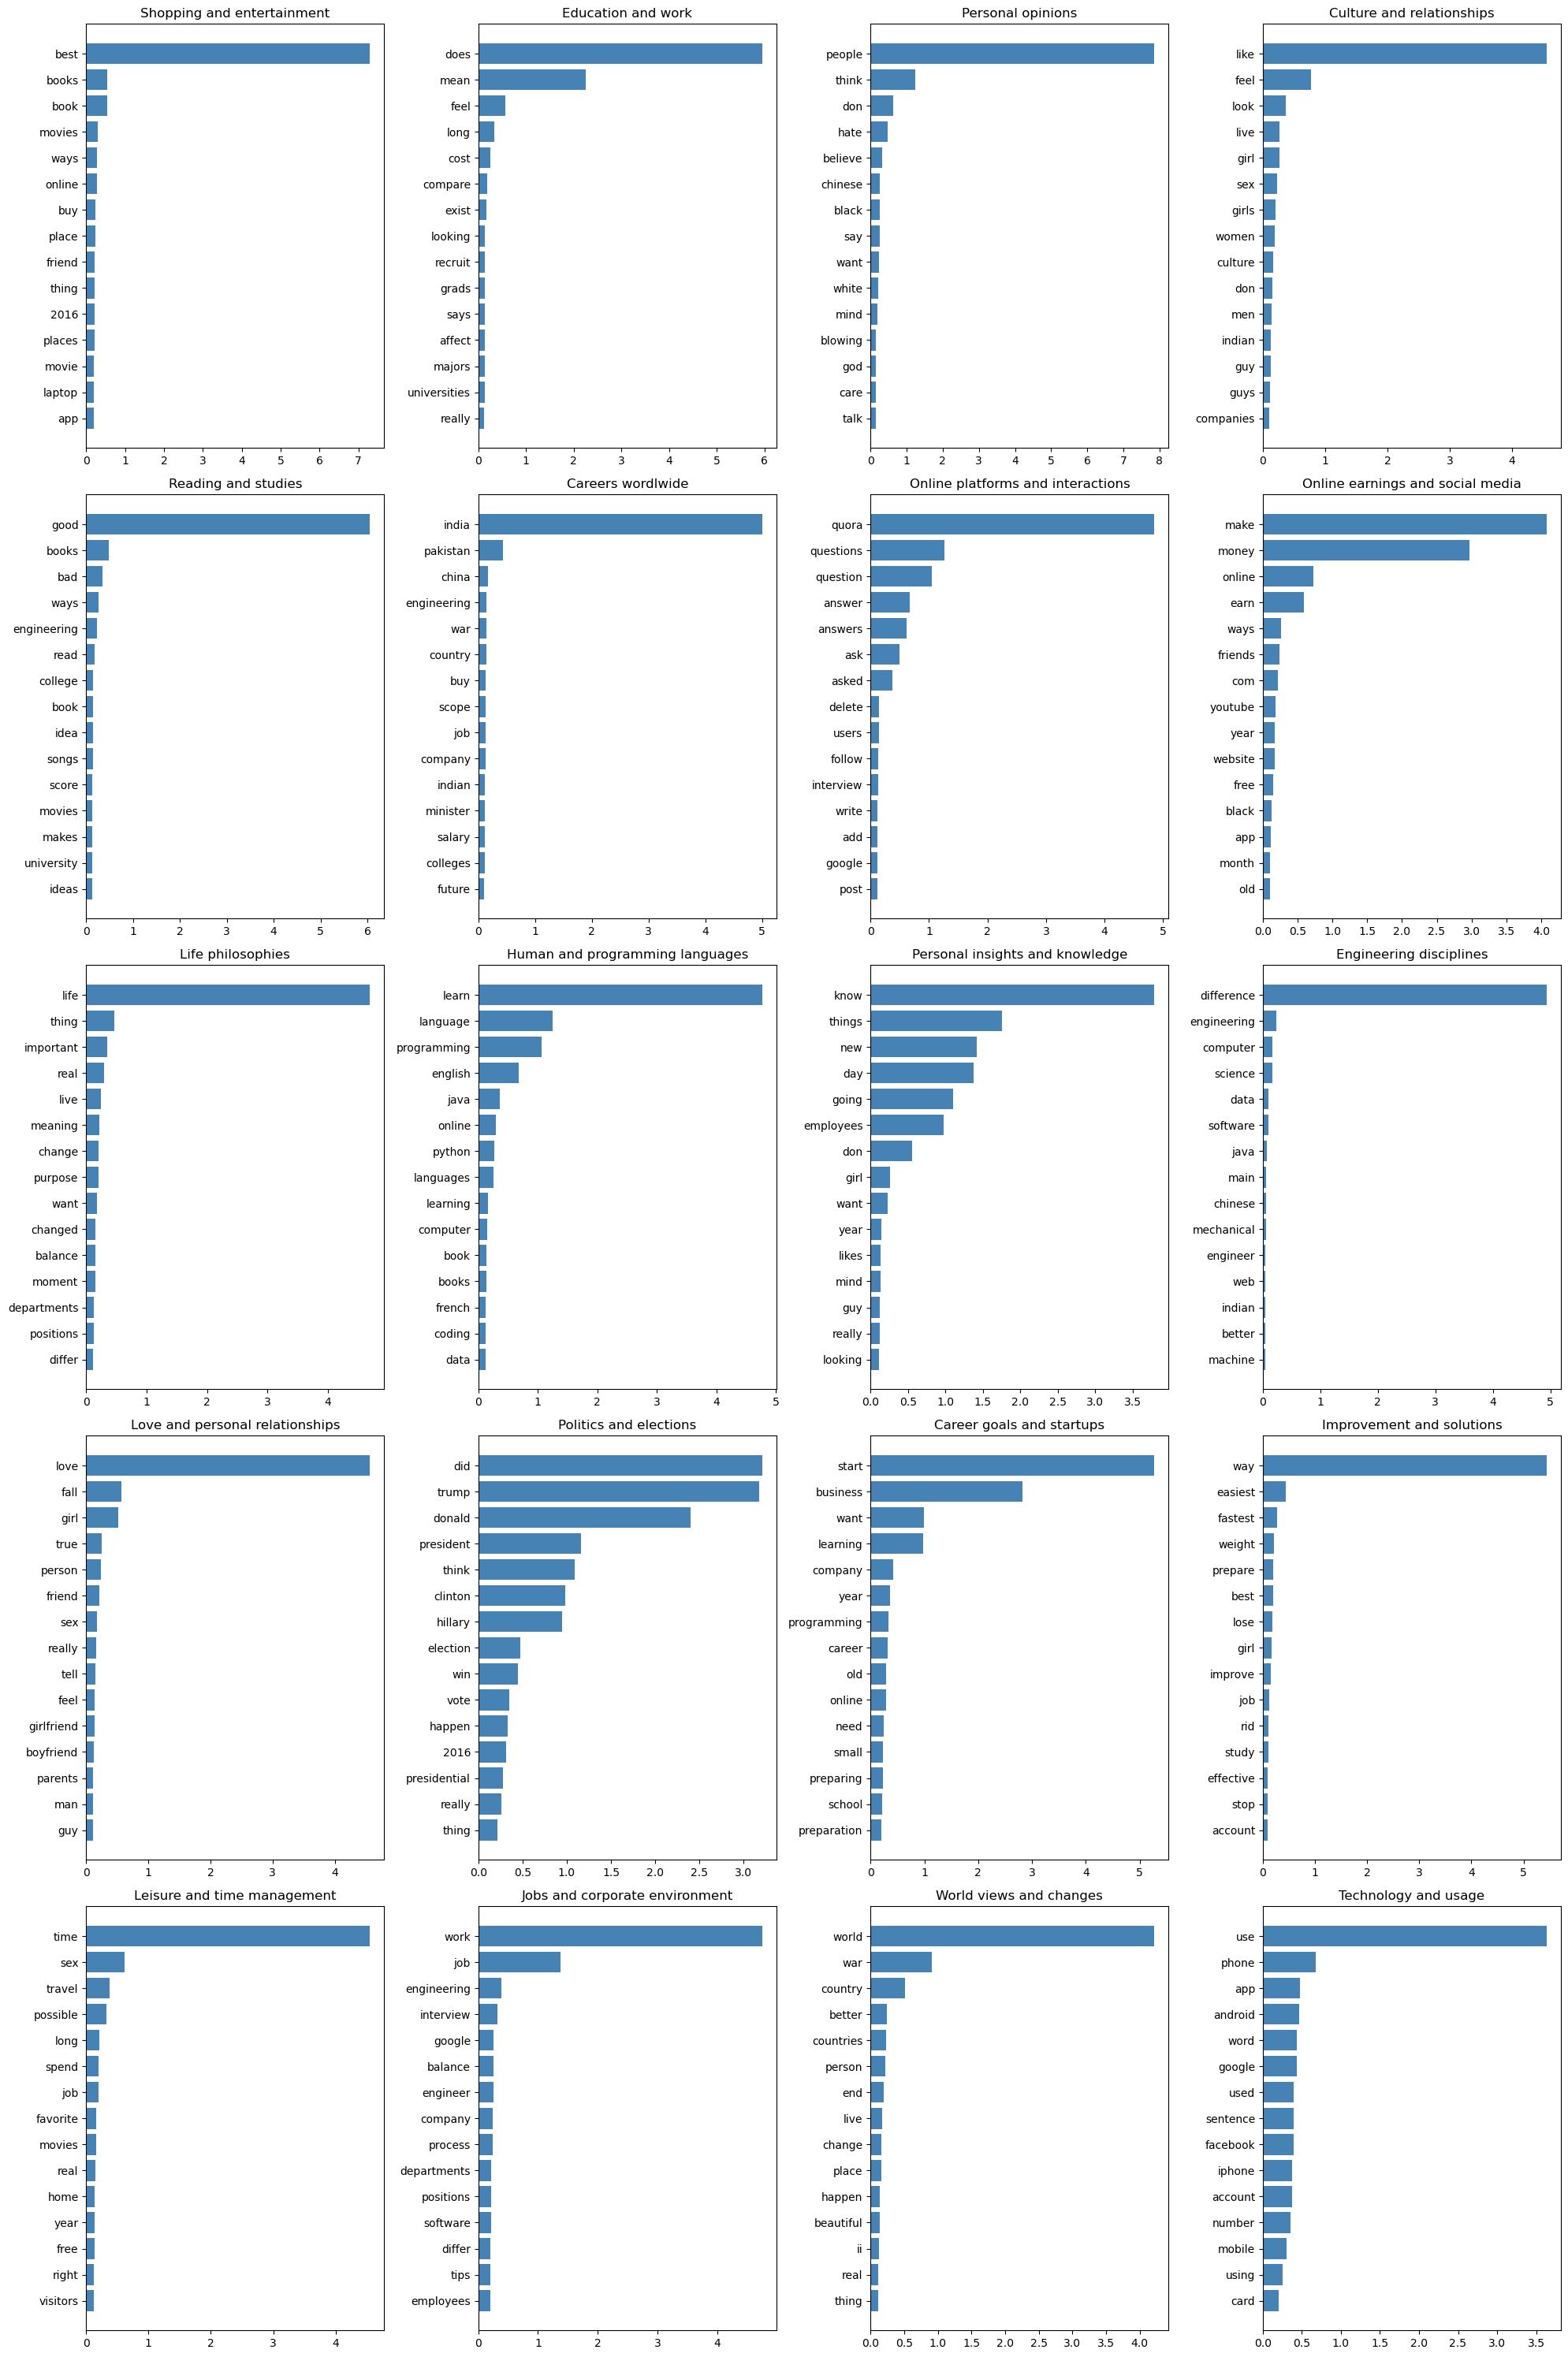

In [15]:
# Создадим функции для отображения топ N слов
def plot_top_words_for_topic(ax, topic_number, tfidf, nmf_model, n_words=15):
    topic = nmf_model.components_[topic_number]
    top_words_indices = topic.argsort()[-n_words:][::-1]
    top_words = [tfidf.get_feature_names_out()[i] for i in top_words_indices]
    top_words_weights = topic[top_words_indices]
    
    ax.barh(top_words, top_words_weights, color='steelblue')
    ax.set_title(topic_labels[topic_number])
    ax.invert_yaxis()

n_rows = int(np.ceil(len(topic_labels) / 4))
n_cols = 4

plt.figure(figsize=(20, 6 * n_rows))

for index, topic_number in enumerate(topic_labels.keys()):
    ax = plt.subplot(n_rows, n_cols, index + 1)
    plot_top_words_for_topic(ax, topic_number, tfidf, nmf_model)

plt.tight_layout()
plt.show()

In [16]:
quora

,Question,topic_number,labels
0,What is the step by step guide to invest in sh...,5,Careers wordlwide
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,12,Love and personal relationships
2,How can I increase the speed of my internet co...,19,Technology and usage
3,Why am I mentally very lonely? How can I solve...,15,Improvement and solutions
4,"Which one dissolve in water quikly sugar, salt...",1,Education and work
...,...,...,...
404282,What do you think of the removal of the MagSaf...,13,Politics and elections
404283,What does Jainism say about homosexuality?,1,Education and work
404286,What is one coin?,5,Careers wordlwide
404287,What is the approx annual cost of living while...,3,Culture and relationships
